In [2]:
#!pip install ortools
from ortools.sat.python import cp_model

Consider square tiles made of $m \times m$ squares where $m = 4$ that can be either black (0) or white (1), such that each tile has an equal number of black and white squares.

We call two tiles equivalent if one can be rotated and/or reflected in order to obtain the other. It is easy to see that a tile can have 1, 2, m or 8 equivalent tiles (including itself).

Your goal: Find a tiling of a $N = 4m$ squares board ($m \times m$ of such tiles, with $m \times m$ squares in each tile). All tiles included in the tiling must be non-equivalent, such that:

1. In each row and column, there are no more than two consecutive squares of the same color.
2. The total number of pairs of adjacent same color squares is minimal. Remember to count both vertical and horizontal pairs.

# Notes

I've simplified this problem down to $N = 2m$ squares board**. I've also only considered two tiles equivalent if one can be **rotated**  in order to obtain the other. Examining the $N = 4m$ squares board as well as reflections of tiles was too computationally complex (>12 hrs for a solution).

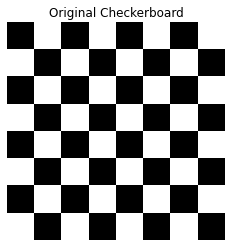

Status = OPTIMAL
Minimum = 10


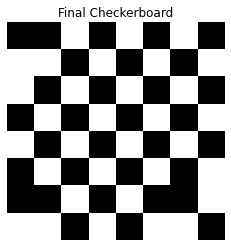

In [18]:
import matplotlib.pyplot as plt
import itertools
import math
import numpy as np

def Solve_Tiles(N, m):
  # Plotting checkerboard
  def checkerboard(shape):
      return np.indices(shape).sum(axis=0) % 2

  board = checkerboard((N,N))
  plt.imshow(board, cmap="binary_r")
  plt.title('Original Checkerboard')
  plt.axis('off');
  plt.show();

  # Creates the model and set solver
  model = cp_model.CpModel()
  solver = cp_model.CpSolver()

  # Board
  x = {(i,j):model.NewBoolVar(f"x_{i}_{j}") for i in range(N) for j in range(N)}

  # Sum of rows
  y_row = {(i,j):model.NewIntVar(-1, 1, f"y_row_{i}_{j}") for i in range(N) for j in range((N-1))}
  y_col = {(j,i):model.NewIntVar(-1, 1, f"y_col_{j}_{i}") for i in range(N) for j in range((N-1))}

  # Sum of rotations
  orig = {(a,i):model.NewIntVar(-1, 1, f"orig_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_lr = {(a,i):model.NewIntVar(-1, 1, f"flip_lr_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_ud = {(a,i):model.NewIntVar(-1, 1, f"flip_ud_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  rot90 = {(a,i):model.NewIntVar(-1, 1, f"rot90_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_lr_90 = {(a,i):model.NewIntVar(-1, 1, f"flip_lr_90_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_ud_90 = {(a,i):model.NewIntVar(-1, 1, f"flip_ud_90_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  rot180 = {(a,i):model.NewIntVar(-1, 1, f"rot180_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}
  
  flip_lr_180 = {(a,i):model.NewIntVar(-1, 1, f"flip_lr_180_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_ud_180 = {(a,i):model.NewIntVar(-1, 1, f"flip_ud_180_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  rot270 = {(a,i):model.NewIntVar(-1, 1, f"rot270_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}
 
  flip_lr_270 = {(a,i):model.NewIntVar(-1, 1, f"flip_lr_270_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}

  flip_ud_270 = {(a,i):model.NewIntVar(-1, 1, f"flip_ud_270_{a}_{i}") for a in range(math.comb(N,2)) for i in range(m**2)}


  # Creating tiles
  # Good
  count = 0
  for k in range(int(N/m)):
    for l in range(int(N/m)):
      tiles = [(i+k*m,j+l*m) for i in range(m) for j in range(m)]
      globals()[f"tile_{count}"] = {(i,j): model.NewBoolVar(f"tile_{count}_{i}_{j}") for i,j in tiles}
      count+=1

  # Linking tiles to board
  # Good
  count = 0
  for k in range(int(N/m)):
    for l in range(int(N/m)):
      for i in range(m):
        for j in range(m):
          model.Add(globals()[f"tile_{count}"][i+k*m,j+l*m] == x[i+k*m,j+l*m])
      count+=1

  #0. Each tile has equal number of black and white squares
  for i in range(int(N**2/(m**2))-1):
    expr1 = [globals()[f'tile_{i}'][j] for j in globals()[f'tile_{i}'].keys()]
    expr2 = [globals()[f'tile_{i+1}'][j] for j in globals()[f'tile_{i+1}'].keys()]
    model.Add(sum(expr1) == sum(expr2))

  #1. In each row and column, there are no more than two consecutive squares of the same color.
  # Good
  for i in range(N):
    for j in range(N-1):
      model.AddAbsEquality(y_row[i,j], x[i,j] - x[i,j+1])
      model.AddAbsEquality(y_col[j,i], x[j,i] - x[j+1,i])

  # At most 2 same adjacent similar squares per row and column
  for i in range(N):
    for j in range(N-2):
      # Rows
      model.Add(x[i,j] + x[i,j+1] + x[i,j+2] <= 2)
      model.Add(x[i,j] + x[i,j+1] + x[i,j+2] >= 1)
      # Cols
      model.Add(x[j,i] + x[j+1,i] + x[j+2,i] <= 2)
      model.Add(x[j,i] + x[j+1,i] + x[j+2,i] >= 1)

  ################################################################################
  # Equivalence checking
  ################################################################################
  def rot90_func(a):
    b = int(math.sqrt(len(a)))
    array = a.copy()
    array = np.reshape(array,(b,b))
    array = np.rot90(array, -1).flatten()
    return array

  def rot180_func(a):
    b = int(math.sqrt(len(a)))
    array = a.copy()
    array = np.reshape(array,(b,b))
    array = np.rot90(array, -2).flatten()
    return array

  def rot270_func(a):
    b = int(math.sqrt(len(a)))
    array = a.copy()
    array = np.reshape(array,(b,b))
    array = np.rot90(array, -3).flatten()
    return array

  def flip_lr_func(a):
    b = int(math.sqrt(len(a)))
    array = a.copy()
    array = np.reshape(array,(b,b))
    array = np.fliplr(array).flatten()
    return array

  def flip_ud_func(a):
    b = int(math.sqrt(len(a)))
    array = a.copy()
    array = np.reshape(array,(b,b))
    array = np.flipud(array).flatten()
    return array

  ################################################################################
  ################################################################################
  count = 0
  for i,j in list(itertools.combinations(list(range(int(N**2/m**2))),2)):
    count2 = 0
    for a in range(m**2):
      
      # Original tile, gathering the differences
      model.AddAbsEquality(orig[count,count2], globals()[f"tile_{i}"][list(globals()[f"tile_{i}"].keys())[a]] \
              - globals()[f"tile_{j}"][list(globals()[f"tile_{j}"].keys())[a]])
      
      # Original tile flipped along x and y, gathering the differences
      exp = list(globals()[f"tile_{i}"].values())
      model.AddAbsEquality(flip_lr[count,count2], flip_lr_func(exp)[a] \
                          - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_ud[count,count2], flip_ud_func(exp)[a] \
                          - list(globals()[f"tile_{j}"].values())[a])

      # 90 degree rotated tile, flipped along x and y, gathering the differences
      exp_90 = rot90_func(list(globals()[f"tile_{i}"].values()))
      model.AddAbsEquality(rot90[count,count2], exp_90[a] - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_lr_90[count,count2], flip_lr_func(exp_90)[a] \
                           - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_ud_90[count,count2], flip_ud_func(exp_90)[a] \
                      - list(globals()[f"tile_{j}"].values())[a])

      # 180 degree rotated tile, flipped along x and y, gathering the differences
      exp_180 = rot180_func(list(globals()[f"tile_{i}"].values()))
      model.AddAbsEquality(rot180[count,count2], exp_180[a] - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_lr_180[count,count2], flip_lr_func(exp_180)[a] \
                           - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_ud_180[count,count2], flip_ud_func(exp_180)[a] \
                      - list(globals()[f"tile_{j}"].values())[a])

      # 270 degree rotated tile, flipped along x and y, gathering the differences
      exp_270 = rot270_func(list(globals()[f"tile_{i}"].values()))
      model.AddAbsEquality(rot270[count,count2], exp_270[a] - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_lr_270[count,count2], flip_lr_func(exp_270)[a] \
                           - list(globals()[f"tile_{j}"].values())[a])
      model.AddAbsEquality(flip_ud_270[count,count2], flip_ud_func(exp_270)[a] \
                      - list(globals()[f"tile_{j}"].values())[a])

      count2+=1

    # Original tile sum of the differences
    exp = [orig[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)

    # Reflect left/right, sum of the differences
    exp = [flip_lr[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)

    # Reflect up/down, sum of the differences
    exp = [flip_ud[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)

    # 90 degree rotation to the right, sum of the differences
    exp = [rot90[count,k] for k in range(m**2)]
    exp2 = [flip_lr_90[count,k] for k in range(m**2)]
    exp3 = [flip_ud_90[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)
    model.Add(sum(exp2) >= 1)
    model.Add(sum(exp3) >= 1)

    # 180 degree rotation to the right, sum of the differences
    exp = [rot180[count,k] for k in range(m**2)]
    exp2 = [flip_lr_180[count,k] for k in range(m**2)]
    exp3 = [flip_ud_180[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)
    model.Add(sum(exp2) >= 1)
    model.Add(sum(exp3) >= 1)

    # 270 degree rotation to the right, sum of the differences
    exp = [rot270[count,k] for k in range(m**2)]
    exp2 = [flip_lr_270[count,k] for k in range(m**2)]
    exp3 = [flip_ud_270[count,k] for k in range(m**2)]
    model.Add(sum(exp) >= 1)
    model.Add(sum(exp2) >= 1)
    model.Add(sum(exp3) >= 1)

    count+=1

  ################################################################################

  #2. The total number of pairs of adjacent same color squares is minimal.
  #   Remember to count both vertical and horizontal pairs.
  
  # Maximizing the sum of adjacent, non-similar squares
  model.Maximize(sum(y_row[i,j] + y_col[j,i] for i in range(N) for j in range(N-1)))

  status = solver.Solve(model)

  print(f"Status = {solver.StatusName(status)}")

  # Solution
  global sol
  global val
  sol = [solver.value(x[i]) for i in x.keys()]
  sol = np.reshape(sol,(N,N))
  val = -1*(sum([solver.value(y_row[i,j]) + solver.value(y_col[j,i]) for i in range(N) for j in range(N-1)]) - 2*(N*(N-1)))
  print(f'Minimum = {val}')

  # Plotting solved checkeroard

  plt.imshow(sol, cmap="binary_r")
  plt.grid(color='b', linestyle='-', linewidth=2, which='minor')
  plt.title('Final Checkerboard')
  plt.axis('off');

# Solve function
Solve_Tiles(N = 8, m = 4)

In [19]:
sol

array([[0, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 0]])